# **Taller 1**

<table align='left'>
<tr>
<td><img src='https://api.cryptosiam.com/assets/1aa01198-ad1b-4525-a947-291c39194a36/bitcoin-options.jpg' width='950'/></td>
</tr>
</table>


# Introducción

La simulación es una técnica computacional que permite modelar procesos o sistemas del mundo real para imitar su comportamiento. Implica crear un entorno virtual para observar y analizar cómo interactúan varios factores, permitiendo la experimentación sin afectar el sistema real. Las simulaciones son valiosas para probar hipótesis científicas, hacer predicciones para la toma de decisiones, optimizar procesos industriales y comprender fenómenos complejos en campos como la ciencia y la ingeniería. En el ámbito financiero, las simulaciones son especialmente útiles para modelar riesgos, valorar activos, simular escenarios económicos y evaluar estrategias de inversión, proporcionando información crucial para la toma de decisiones en un entorno económico dinámico.



En este taller simularemos comportamiento de los precios de ciertos activos en el tiempo utilizando un modelo estocástico sencillo denominado "Movimiento Browniano Geométrico" (GBM). Este modelo se ha utilizado para modelar diversos tipos de instrumentos financieros, incluyendo acciones, bonos, materias primas y criptomonedas como Bitcoin.

# Disclaimer

El modelo y los instrumentos financieros estudiados en este taller han sido seleccionados con fines puramente académicos.  
Las conclusiones que puedan derivarse de este taller podrían no reflejar la realidad con precisión y en ningún caso deben entenderse como un consejo de inversión.

# Modelo

El modelo GBM se utiliza para describir la dinámica del precio de un activo $S$ a lo largo del tiempo $t$. Se define mediante la siguiente ecuación diferencial estocástica:

\begin{align}
dS_t &= \mu S_t dt + \sigma S_t dW_t \, ,
\end{align}
donde



*  $S_t$ es el precio del activo en el tiempo $t$.
*  $\mu$ es la tasa promedio de retorno (deriva) del activo.
*  $\sigma$ es la volatilidad de los rendimientos del activo.
*  $W_t$ es un proceso de Wiener (movimiento Browniano) que representa la componente aleatoria.


En forma discreta y considerando incrementos temporales constantes $dt=1$,la ecuación se puede escribir como:
\begin{align}
R_t = \frac{S_{t+1}-S_t}{S_t} &= \mu + \sigma S_t Z_t \, ,
\end{align}
donde
*  $R_t$ es el retorno en el tiempo $t$.
*  $Z_t$ es variable aleatoria independiente de cualquier información del pasado.


# Datos & Libs

Utilizaremos algunas librerías básicas de Python para trabajo con datos.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(8,4)})

from scipy.stats import norm, lognorm, t, laplace
import scipy.stats as stats

plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)

Utilizaremos datos correspondientes al precio del oro (GC:F) y del Bitcoin en dólares americanos (USD). Para descargarlos podemos emplear la librería yfinance.

In [2]:
#!pip install yfinance > /dev/null
import yfinance as yf

In [144]:
def pre_process(finance_dataframe):
  finance_dataframe = finance_dataframe.rename(columns = {'Close':'price'})
  finance_dataframe.index.name = 'timestamp'
  finance_dataframe['timestamp'] = finance_dataframe.index
  finance_dataframe.reset_index(drop=True, inplace=True)
  finance_dataframe.timestamp = pd.to_datetime(finance_dataframe.timestamp, unit='s').dt.tz_localize(None)
  finance_dataframe.set_index(finance_dataframe.timestamp, inplace=True)
  finance_dataframe.drop(['timestamp'], axis=1, inplace=True)
  finance_dataframe.sort_values(by='timestamp', inplace = True)
  finance_dataframe['delta'] = finance_dataframe.diff().price
  finance_dataframe = finance_dataframe.dropna()
  finance_dataframe['return'] = finance_dataframe.delta/finance_dataframe.price
  finance_dataframe['logprice'] = np.log(1+finance_dataframe.price)
  return finance_dataframe

In [145]:
btc_data = yf.download('BTC-USD', interval = '1d')[['Close']]
btc_data = pre_process(btc_data)
print(btc_data.head(5))
print("Fecha Mínima: ", btc_data.iloc[[0]].index)
print("Fecha Máxima: ", btc_data.iloc[[-1]].index)

[*********************100%%**********************]  1 of 1 completed
                 price      delta    return  logprice
timestamp                                            
2014-09-18  424.440002 -32.894012 -0.077500  6.053124
2014-09-19  394.795990 -29.644012 -0.075087  5.980899
2014-09-20  408.903992  14.108002  0.034502  6.015923
2014-09-21  398.821014 -10.082977 -0.025282  5.991017
2014-09-22  402.152008   3.330994  0.008283  5.999314
Fecha Mínima:  DatetimeIndex(['2014-09-18'], dtype='datetime64[ns]', name='timestamp', freq=None)
Fecha Máxima:  DatetimeIndex(['2023-08-17'], dtype='datetime64[ns]', name='timestamp', freq=None)


In [146]:
gold_data = yf.download('GC=F', interval = '1d')[['Close']]
gold_data = pre_process(gold_data)
print(gold_data.head(5))
print("Fecha Mínima: ", gold_data.iloc[[0]].index)
print("Fecha Máxima: ", gold_data.iloc[[-1]].index)

[*********************100%%**********************]  1 of 1 completed
                 price     delta    return  logprice
timestamp                                           
2000-08-31  278.299988  4.399994  0.015810  5.632286
2000-09-01  277.000000 -1.299988 -0.004693  5.627621
2000-09-05  275.799988 -1.200012 -0.004351  5.623295
2000-09-06  274.200012 -1.599976 -0.005835  5.617498
2000-09-07  274.000000 -0.200012 -0.000730  5.616771
Fecha Mínima:  DatetimeIndex(['2000-08-31'], dtype='datetime64[ns]', name='timestamp', freq=None)
Fecha Máxima:  DatetimeIndex(['2023-08-17'], dtype='datetime64[ns]', name='timestamp', freq=None)


In [182]:
btc_data_history = btc_data.loc[(btc_data.index >= '2014-09-18') & (btc_data.index <= '2022-08-16')]
btc_data_future= btc_data.loc[(btc_data.index >= '2022-08-17') & (btc_data.index <= '2023-08-17')]

In [183]:
gold_data_history = gold_data.loc[(gold_data.index >= '2000-08-31') & (gold_data.index <= '2022-08-16')]
gold_data_future = gold_data.loc[(gold_data.index >= '2022-08-17') & (gold_data.index <= '2023-08-17')]

# Actividades


1.   Averigue en qué consisten las herramientas estadísticas denominadas Histograma y KDE (Kernel Density Estimation). Use esa información para interpretar el significado de los siguientes gráficos de los retornos diarios de ambos tipos de inversión.


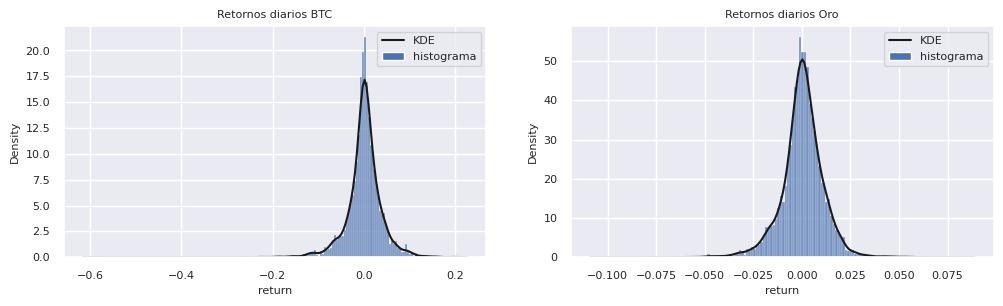

In [28]:
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=2)
sns.histplot(btc_data_history, x='return',stat='density',ax=ax[0])
sns.kdeplot(btc_data_history, x='return',ax=ax[0],color='k')
ax[0].set_title('Retornos diarios BTC',size=8)
ax[0].legend(['KDE','histograma'],fontsize=8)

sns.histplot(gold_data_history, x='return',stat='density',ax=ax[1])
sns.kdeplot(gold_data_history, x='return',ax=ax[1],color='k')
ax[1].set_title('Retornos diarios Oro',size=8)
ax[1].legend(['KDE','histograma'],fontsize=8)
plt.show()

2.   Determine la media y la desviación estándar de los retornos diarios históricos de cada instrumento financiero. ¿Qué instrumento renta más en promedio? ¿Qué instrumento es más volátil en promedio?

In [29]:
mu_btc = np.mean(btc_data_history['return'].values)
sigma_btc = np.std(btc_data_history['return'].values,ddof=1)
print("Retorno medio BTC: %f%%, Sigma=%f"%(100*mu_btc,sigma_btc))

mu_gold = np.mean(gold_data_history['return'].values)
sigma_gold = np.std(gold_data_history['return'].values,ddof=1)
print("Retorno medio GOLD: %f%%, Sigma=%f"%(100*mu_gold,sigma_gold))

Retorno medio BTC: 0.059836%, Sigma=0.039816
Retorno medio GOLD: 0.027794%, Sigma=0.011068


3.   Ajuste una distribución normal a los retornos diarios de cada instrumento financiero. Usando el modelo, determine la probabilidad de que cada instrumento retorne más del 0.5% en un día. Haga el cálculo a mano y usando una librería. Averigue también cómo se definen los cuartíles de una distribución y calcúlelos para cada modelo. Contraste todos los valores obtenidos a partir del modelo con los valores empíricos observados.

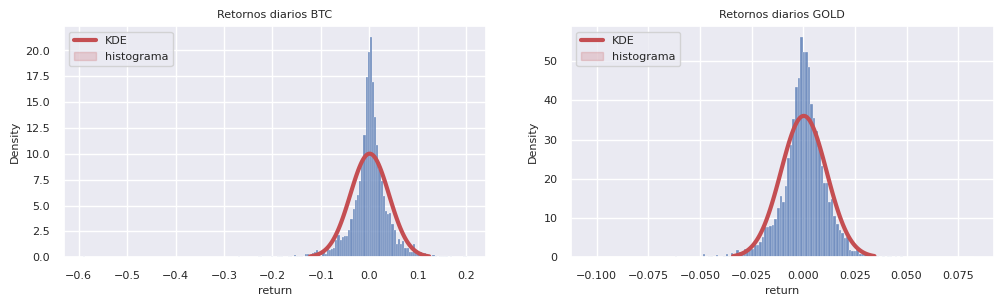

In [30]:
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=2)
rv_btc = norm(loc=mu_btc,scale=sigma_btc)
x = np.linspace(rv_btc.ppf(0.001), rv_btc.ppf(0.999), 100)
sns.lineplot(x=x,y=rv_btc.pdf(x),lw=3,label='modelo retorno',color='r',ax=ax[0])
sns.histplot(btc_data_history, x='return',label='histograma retornos',stat='density',ax=ax[0],color='b')
ax[0].set_title('Retornos diarios BTC',size=8)
ax[0].legend(['KDE','histograma'],fontsize=8,loc='upper left')

rv_gold = norm(loc=mu_gold,scale=sigma_gold)
x = np.linspace(rv_gold.ppf(0.001), rv_gold.ppf(0.999), 100)
sns.lineplot(x=x,y=rv_gold.pdf(x),lw=3,label='modelo retorno',color='r',ax=ax[1])
sns.histplot(gold_data_history, x='return',label='histograma retornos',stat='density',ax=ax[1],color='b')
ax[1].set_title('Retornos diarios GOLD',size=8)
ax[1].legend(['KDE','histograma'],fontsize=8,loc='upper left')
plt.show()

In [31]:
p_btc_emp = len(btc_data_history[btc_data_history['return']>0.005])/len(btc_data_history)
p_gold_emp = len(gold_data_history[gold_data_history['return']>0.005])/len(gold_data_history)
p_btc_teo = 1-rv_btc.cdf(0.005)
p_gold_teo = 1-rv_gold.cdf(0.005)
print(p_btc_emp,p_btc_teo)
print(p_gold_emp,p_gold_teo)

0.43217993079584777 0.45598667619606637
0.289760348583878 0.33482598497735605


In [32]:
q_btc_emp = np.quantile(btc_data_history['return'].values,q=0.75)
q_gold_emp = np.quantile(gold_data_history['return'].values,q=0.75)
q_btc_teo = rv_btc.ppf(0.75)
q_gold_teo = rv_gold.ppf(0.75)
print(q_btc_emp,q_btc_teo)
print(q_gold_emp,q_gold_teo)

0.017854715593214714 0.02745376166049753
0.006119749340555691 0.007743453829637204


4.   Modifique el modelo anterior usando una distribución de Laplace en vez de una distribución normal. Comente. Recuerde hacer los cálculos asociados al modelo tanto a mano como usando una librería.

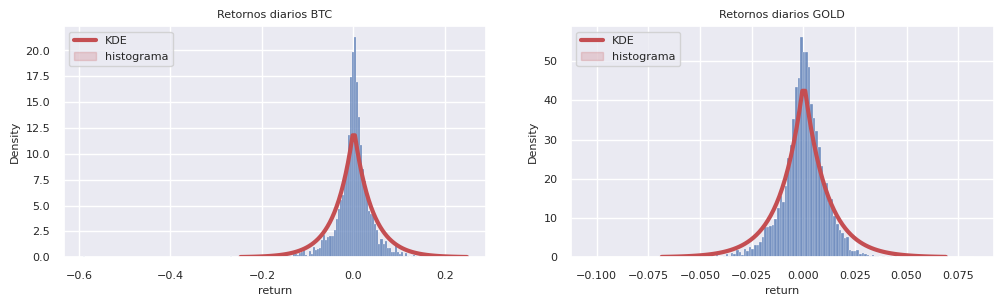

In [33]:
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=2)
rv_btc = laplace(loc=mu_btc,scale=sigma_btc)
x = np.linspace(rv_btc.ppf(0.001), rv_btc.ppf(0.999), 100)
sns.lineplot(x=x,y=rv_btc.pdf(x),lw=3,label='modelo retorno',color='r',ax=ax[0])
sns.histplot(btc_data_history, x='return',label='histograma retornos',stat='density',ax=ax[0],color='b')
ax[0].set_title('Retornos diarios BTC',size=8)
ax[0].legend(['KDE','histograma'],fontsize=8,loc='upper left')

rv_gold = laplace(loc=mu_gold,scale=sigma_gold)
x = np.linspace(rv_gold.ppf(0.001), rv_gold.ppf(0.999), 100)
sns.lineplot(x=x,y=rv_gold.pdf(x),lw=3,label='modelo retorno',color='r',ax=ax[1])
sns.histplot(gold_data_history, x='return',label='histograma retornos',stat='density',ax=ax[1],color='b')
ax[1].set_title('Retornos diarios GOLD',size=8)
ax[1].legend(['KDE','histograma'],fontsize=8,loc='upper left')
plt.show()

In [34]:
p_btc_emp = len(btc_data_history[btc_data_history['return']>0.005])/len(btc_data_history)
p_gold_emp = len(gold_data_history[gold_data_history['return']>0.005])/len(gold_data_history)
p_btc_teo = 1-rv_btc.cdf(0.005)
p_gold_teo = 1-rv_gold.cdf(0.005)
print(p_btc_emp,p_btc_teo)
print(p_gold_emp,p_gold_teo)

0.43217993079584777 0.44767086783087495
0.289760348583878 0.32635390494401295


In [35]:
q_btc_emp = np.quantile(btc_data_history['return'].values,q=0.75)
q_gold_emp = np.quantile(gold_data_history['return'].values,q=0.75)
q_btc_teo = rv_btc.ppf(0.75)
q_gold_teo = rv_gold.ppf(0.75)
print(q_btc_emp,q_btc_teo)
print(q_gold_emp,q_gold_teo)

0.017854715593214714 0.028196623553720736
0.006119749340555691 0.007949961390433077


5.   Asumiendo independencia de los valores de ambos instrumentos financieros y adoptando uno de los modelos anteriores (normal o Laplace), use la ley de los grandes números para estimar la probabilidad de que en 1 día Oro rente más que BTC.

In [195]:
N_SIMS = 1000
rv_btc = laplace(loc=mu_btc,scale=sigma_btc)
rv_gold = laplace(loc=mu_gold,scale=sigma_gold)
simulaciones_btc = rv_btc.rvs(size=N_SIMS)
simulaciones_gold = rv_gold.rvs(size=N_SIMS)
p_gold_better = np.sum(simulaciones_gold > simulaciones_btc)/NSIMS
print(p_gold_better)

0.502


In [196]:
##real
joined = btc_data_history.merge(gold_data_history,left_index=True, right_index=True,suffixes=('_btc', '_gold'))
p_gold_better = np.sum(joined['return_gold'] > joined['return_btc'])/len(joined)
print(p_gold_better)

0.4675716440422323


6.   Partiendo del valor observado el 17 de Agosto de 2022, simule los valores de cada activo 1 año hacia adelante. Para simular los valores de $Z_t$ utilice uno de los modelos explorados más arriba. Grafique 1000 trayectorias posibles y compute los percentiles 80 y 20 para cada tiempo $t$, calculando con qué frecuencia cubren los valores reales observados.

In [142]:
def simulate_one_from_dist(ndays,starting_price,rv):
    simulated_values = np.zeros(ndays)
    simulated_values[0] = starting_price
    for i in range(1,ndays):
      return_value = rv.rvs(size=1)
      value = (1+return_value)*simulated_values[i-1]
      simulated_values[i] = value
    return simulated_values

def simulate_many_from_dist(nsims,ndays,starting_price,rv):
    simulated_values = np.zeros((nsims,ndays))
    for i in range(nsims):
      simulated_values[i,:] = simulate_one_from_dist(ndays,starting_price,rv)
    return simulated_values

In [143]:
NSIMS = 1000
n_days = len(btc_data_future)
rv_btc = norm(loc=mu_btc,scale=sigma_btc)
starting_value = btc_data_future.iloc[[0]].price
sim_values_btc = simulate_many_from_dist(NSIMS,n_days,starting_value,rv_btc)

In [93]:
low_btc = np.quantile(sim_values_btc,q=0.2,axis=0)
up_btc = np.quantile(sim_values_btc,q=0.8,axis=0)
print(low_btc.shape)

(366,)


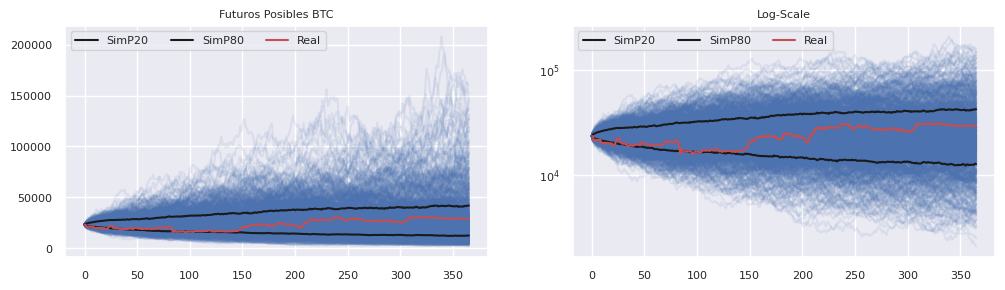

In [94]:
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=2)
for i in range(NSIMS):
  ax[0].plot(sim_values_btc[i,:],color='b',alpha=0.1)
ax[0].plot(low_btc,color='k',label='SimP20')
ax[0].plot(up_btc,color='k',label='SimP80')
ax[0].plot(btc_data_future['price'].values,color='r',label='Real')
ax[0].set_title('Futuros Posibles BTC',size=8)
ax[0].legend(loc='upper left',fontsize=8,ncol=3)

for i in range(NSIMS):
  ax[1].plot(sim_values_btc[i,:],color='b',alpha=0.1)
ax[1].plot(low_btc,color='k',label='SimP20')
ax[1].plot(up_btc,color='k',label='SimP80')
ax[1].plot(btc_data_future['price'].values,color='r',label='Real')
ax[1].set_title('Log-Scale',size=8)
ax[1].legend(loc='upper left',fontsize=8,ncol=3)
ax[1].set_yscale('log')

In [95]:
coverage_btc = (btc_data_future.price >= low_btc) & (btc_data_future.price <= up_btc)
p_coverage_btc = np.sum(coverage_btc)/len(coverage_btc)
print(p_coverage_btc)

0.9180327868852459


7.   Modifique su simulación anterior de manera que los valores de $Z_t$ se seleccionen aleatoriamente con reemplazo desde la serie de valores históricos. Comente sobre la sensatez de este procedimiento. Grafique 1000 trayectorias posibles y compute los percentiles 80 y 20 para cada tiempo $t$, calculando con qué frecuencia cubren los valores reales observados.

In [86]:
def simulate_with_bootstrap(ndays,starting_price,historical_returns):
    simulated_values = np.zeros(ndays)
    simulated_values[0] = starting_price
    zs = np.random.choice(historical_returns,size=ndays,replace=True)
    for i in range(1,ndays):
      value = (1+zs[i])*simulated_values[i-1]
      simulated_values[i] = value
    return simulated_values

def simulate_many_with_bootstrap(nsims,ndays,starting_price,historical_returns):
    simulated_values = np.zeros((nsims,ndays))
    for i in range(nsims):
      simulated_values[i,:] = simulate_with_bootstrap(ndays,starting_price,historical_returns)
    return simulated_values

In [87]:
NSIMS = 1000
n_days = len(btc_data_future)
historical_returns_btc = btc_data_history['return'].values
starting_value = btc_data_future.iloc[[0]].price
sim_values_btc = simulate_many_with_bootstrap(NSIMS,n_days,starting_value,historical_returns_btc)

In [88]:
low_btc = np.quantile(sim_values_btc,q=0.2,axis=0)
up_btc = np.quantile(sim_values_btc,q=0.8,axis=0)
print(low_btc.shape)

(366,)


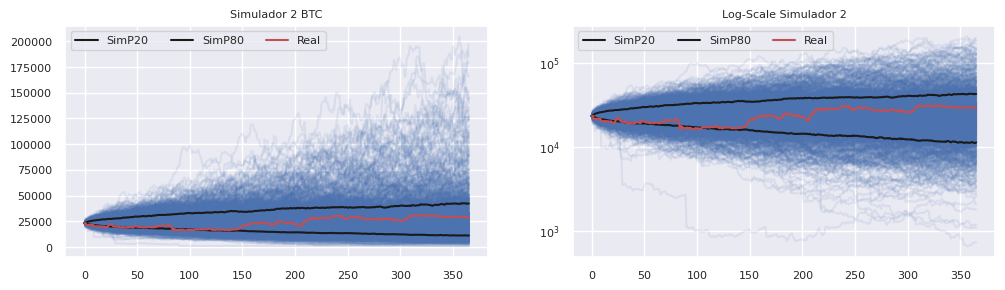

In [89]:
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=2)
for i in range(NSIMS):
  ax[0].plot(sim_values_btc[i,:],color='b',alpha=0.1)
ax[0].plot(low_btc,color='k',label='SimP20')
ax[0].plot(up_btc,color='k',label='SimP80')
ax[0].plot(btc_data_future['price'].values,color='r',label='Real')
ax[0].set_title('Simulador 2 BTC',size=8)
ax[0].legend(loc='upper left',fontsize=8,ncol=3)

for i in range(NSIMS):
  ax[1].plot(sim_values_btc[i,:],color='b',alpha=0.1)
ax[1].plot(low_btc,color='k',label='SimP20')
ax[1].plot(up_btc,color='k',label='SimP80')
ax[1].plot(btc_data_future['price'].values,color='r',label='Real')
ax[1].set_title('Log-Scale Simulador 2',size=8)
ax[1].legend(loc='upper left',fontsize=8,ncol=3)
ax[1].set_yscale('log')

In [90]:
coverage_btc = (btc_data_future.price >= low_btc) & (btc_data_future.price <= up_btc)
p_coverage_btc = np.sum(coverage_btc)/len(coverage_btc)
print(p_coverage_btc)

0.8743169398907104


8.   Utilice su simulación para estimar la probabilidad de que al comprar 1 unidad de BTC a un precio cercano a los 20000 USD se obtenga una utilidad mayor al 20% al cabo de un año. Estime también la probabilidad de que el instrumento pierda el 20% de su valor o más al cabo de un año. Repita la estimación considerando un horizonte de 2 años.

In [100]:
NSIMS = 1000
n_days = 2*366
rv_btc = norm(loc=mu_btc,scale=sigma_btc)
starting_value = 20000
sim_values_btc = simulate_many_from_dist(NSIMS,n_days,starting_value,rv_btc)
values_one_year = sim_values_btc[:,366]
values_two_years = sim_values_btc[:,-1]

In [101]:
prob_plus20_one_year = np.sum(values_one_year>(1.2*starting_value))/NSIMS
prob_plus20_two_years = np.sum(values_two_years>(1.2*starting_value))/NSIMS
print(prob_plus20_one_year,prob_plus20_two_years)

0.367 0.368


In [102]:
prob_minus20_one_year = np.sum(values_one_year<(0.8*starting_value))/NSIMS
prob_minus20_two_years = np.sum(values_two_years<(0.8*starting_value))/NSIMS
print(prob_minus20_one_year,prob_minus20_two_years)

0.419 0.483


9.   Es fácil demostrar que si los precio de un activo efectivamente siguen un movimiento Browniano con retornos distribuidos normalmente $Z_t = \mathcal{N}(\mu,\sigma^2)$, entonces
\begin{align}
S_{t+\Delta t} = S_t \cdot \exp(R_{\Delta t}) \ \Rightarrow \  \ln S_{t+\Delta t} = \ln S_{t} + R_{\Delta t}\, ,
\end{align}
donde
\begin{align}
R_{\Delta t} \sim \mathcal{N}((\mu-\sigma^2/2)\Delta t,\sigma^2\Delta t) \, ,
\end{align}


Partiendo del valor observado el 17 de Agosto de 2022, simule los valores de cada activo 1 año hacia adelante y grafique la distribución empírica del logaritmo de los valores finales. Usando la ley de los grandes números, estime el valor esperado y la varianza del logaritmo del precio del activo el 17 de Agosto de 2023. Compare la distribución empírica y las estimaciones obtenidas con los valores teóricos.

In [152]:
NSIMS = 1000
n_days = len(btc_data_future)
rv_btc = norm(loc=mu_btc,scale=sigma_btc)
starting_value = btc_data_future.iloc[[0]].price
sim_values_btc = simulate_many_from_dist(NSIMS,n_days,starting_value,rv_btc)

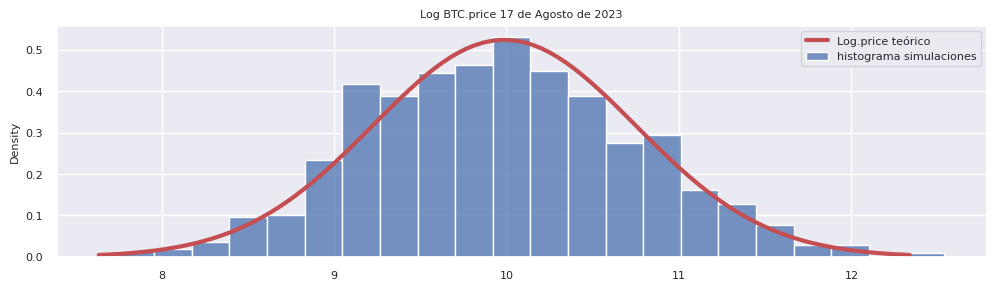

In [170]:
last_values = np.log(sim_values_btc[:,-1])
delta_t = n_days - 1
mu_final_btc = np.log(starting_value.values[0])+(mu_btc - (sigma_btc**2)/2)*delta_t
sigma_final_btc = np.sqrt(delta_t*sigma_btc**2)
rv_final_btc = norm(loc=mu_final_btc,scale=sigma_final_btc)
x = np.linspace(rv_final_btc.ppf(0.001), rv_final_btc.ppf(0.999), 100)
y = rv_final_btc.pdf(x)

fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=1)
sns.histplot(last_values,stat='density',ax=ax,label='histograma simulaciones')
sns.lineplot(x=x,y=y,lw=3,label='Log.price teórico',color='r',ax=ax)
ax.set_title('Log BTC.price 17 de Agosto de 2023',size=8)
ax.legend(fontsize=8)

In [181]:
exp_value_emp = np.mean(last_values)
var_value_emp = np.var(last_values)
print("LogPrice Estimado al 17 de Agosto de 2023")
print("Valor Esperado vía Grandes Números: ", exp_value_emp)
print("Valor Esperado Teórico: ", mu_final_btc)
print("Varianza vía Grandes Números: ", var_value_emp)
print("Varianza Teórica: ", sigma_final_btc**2)
print("Intervalo Valor Esperado +/- STD", exp_value_emp-np.sqrt(var_value_emp),exp_value_emp+np.sqrt(var_value_emp))
print("Valor real al día: ", btc_data_future.iloc[[-1]].index.values[0], " ", np.log(btc_data_future.iloc[[-1]].price.values[0]))

LogPrice Estimado al 17 de Agosto de 2023
Valor Esperado vía Grandes Números:  9.966987921701982
Valor Esperado Teórico:  9.986836931120937
Varianza vía Grandes Números:  0.6013522790138668
Varianza Teórica:  0.5786358900164832
Intervalo Valor Esperado +/- STD 9.191518851387848 10.742456992016116
Valor real al día:  2023-08-17T00:00:00.000000000   10.25342522302454


10. Estudie el efecto del número de simulaciones en las estimaciones realizadas para las preguntas 5, 6 y 9.